In [1]:
import MeCab
import emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core.common import flatten
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec
from xgboost import XGBClassifier
from collections import Counter

plt.style.use('seaborn-paper')

In [2]:
df = pd.read_csv(r"C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\data\utapass_and_kkbox_total_reviews_20200422.csv")
df = df[["content", "rating"]]
df.columns = ["content", "label"]
df["content"] = df["content"].apply(str)
df["label"] = df["label"].apply(int)
df["label"] = df["label"].map(lambda x: 1 if int(x)>3 else 0)

In [3]:
df

,content,label
0,いちいちアプリを立ち上げてライブラリから曲を選択して再生…。 非常に不便です。 時間がたって...,0
1,他の携帯繋げても無料で聴けるのはいい。でも月額払って仮に間違えて違う曲を保存した時に削除する...,0
2,初めて使ったが、どんなアーティストがいるか、わからないので、アーティスト別検索見てたら、全ア...,0
3,ログインボタンを押すと「不明なエラー」と表示されます…不明なエラーとはいったい？長年auユー...,0
4,音質もいいしBluetoothにつないで車の中で聴くのがお気に入りです。 毎日更新されるのも...,1
...,...,...
3494,最低,0
3495,パーフェクト,1
3496,Good,0
3497,最高,1


In [4]:
df["length"] = df["content"].map(len)
text_len = df["length"].values
max_len = text_len.max()

len_sum = [0] * max_len
for i in text_len:
    len_sum[i-1] += 1
    
len_cum = [len_sum[0]] + [0] * (max_len-1)
for i in range(1, max_len):
    len_cum[i] += len_sum[i] + len_cum[i-1]

print('Cumulative %   # Words  # Comments')
for i in range(max_len):
    len_cum[i] /= len(text_len)
    if len_sum[i] != 0:
        if (len_cum[i] >= 0.8 and len_cum[i-1] < 0.8):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.85 and len_cum[i-1] < 0.85):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.9 and len_cum[i-1] < 0.9):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.92 and len_cum[i-1] < 0.92):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.95 and len_cum[i-1] < 0.95):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))

Cumulative %   # Words  # Comments
 80.28008   	  61 	    19
 85.11003   	  74 	    12
 90.19720   	  93 	    8
 92.11203   	  103 	    10
 95.05573   	  127 	    2


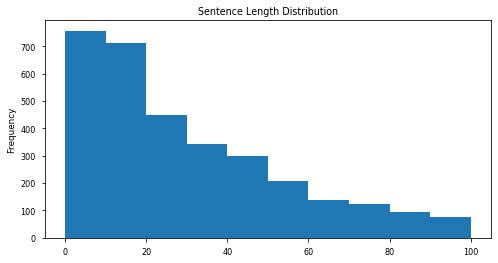

In [5]:
df["length"].plot(kind="hist", 
                  title="Sentence Length Distribution", 
                  range=(0, 100), 
                  figsize=(8, 4))

In [6]:
df = df[df["length"] >= 10]
train, test = train_test_split(df, train_size=0.9, random_state=17)

In [7]:
def create_mecab_list(text):
    pos_list = [10, 11, 31, 32, 34]
    pos_list.extend(list(range(36,50)))
    pos_list.extend([59, 60, 62, 67])

    mecab_list = []
    mecab = MeCab.Tagger("-Ochasen")
    mecab.parse("")
    # encoding = text.encode('utf-8')
    node = mecab.parseToNode(text)
    while node:
        if len(node.surface) > 1:
            if node.posid in pos_list:
                morpheme = node.surface
                mecab_list.append(morpheme)
        node = node.next
    return mecab_list

def remove_stopwords(text):
    stopwords = pd.read_csv("C:/Users/YangWang/Desktop/Text_Classifier_for_UtaPass_and_KKBOX/Japanese_stopword_list.txt", 
                    encoding="utf-8", header=None, sep="\n")
    stopwords = list(flatten(stopwords.values.tolist()))
    filtered_words = [word for word in text if word not in stopwords]
    return "".join(filtered_words)

def give_emoji_free_text(text):
    allchars = [string for string in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    cleaned_text = ''.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return cleaned_text

def clean_text(text):
    text = remove_stopwords(text)
    text = give_emoji_free_text(text)
    text = create_mecab_list(text)
    return text

In [8]:
class Word2VecVectorizer:
    def __init__(self):
        print("Loading word vectors...")
        self.w2v = Word2Vec.load(r"C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\word2vec\ja.bin")
        print("Finished loading in word vectors.")
        
    def fit(self, data):
        pass
    
    def transform(self, data):
        v = self.w2v.wv.get_vector("の")
        self.D = v.shape[0]
        
        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0
        for sentence in data:
            tokens = create_mecab_list(sentence)
            vecs = []
            m = 0
            for word in tokens:
                try: 
                    vec = self.w2v.wv.get_vector(word)
                    vecs.append(vec)
                    m += 1
                except KeyError:
                    pass
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        print("Number of samples with no words found: %s / %s" % (emptycount, len(data)))
        return X
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [9]:
vectorizer = Word2VecVectorizer()
x_train = vectorizer.fit_transform(train.content)
y_train = train.label

x_test = vectorizer.fit_transform(test.content)
y_test = test.label

Loading word vectors...
Finished loading in word vectors.
Number of samples with no words found: 329 / 2467
Number of samples with no words found: 31 / 275


In [10]:
print("# of training data: {}\n# of features: {}".format(x_train.shape[0], x_train.shape[1]))
x_train

# of training data: 2467
# of features: 300


array([[-1.57018113, -0.26452327,  1.21205962, ...,  0.39846775,
        -0.00379243,  0.55407727],
       [-0.85002381,  0.33833307,  0.60584986, ...,  0.02884466,
         0.31363925, -0.54602474],
       [-0.27264288,  0.37544754,  0.16551086, ..., -0.02856954,
        -0.25689915, -0.33307162],
       ...,
       [-1.27766061, -0.12002245,  0.39763317, ...,  2.00929737,
        -0.41422769, -1.4116869 ],
       [-0.44685814,  0.19290257,  0.66804117, ...,  0.57713288,
         0.41261983,  0.3783901 ],
       [-0.79977345, -0.03050352, -0.03237534, ...,  1.67542517,
        -0.34743407, -1.31029689]])

In [11]:
def performance(model, x_train, y_train, x_test, y_test):
    print("train score: ", round(model.score(x_train, y_train), 4))
    print("test score: ", round(model.score(x_test, y_test), 4))
    print("f-beta score: ", round(f1_score(y_test, model.predict(x_test)), 4))
    print("roc auc score: ", round(roc_auc_score(y_test, model.predict(x_test)), 4))
    print("confusion matrix: \n", confusion_matrix(y_test, model.predict(x_test)))

In [12]:
rfc_model = RandomForestClassifier(
    n_estimators=200, 
    random_state=17)
rfc_model.fit(x_train, y_train)
performance(rfc_model, x_train, y_train, x_test, y_test)

train score:  0.9039
test score:  0.6945
f-beta score:  0.6
roc auc score:  0.6745
confusion matrix: 
 [[128  38]
 [ 46  63]]


In [13]:
knn_model = KNeighborsClassifier(
    n_neighbors=10)
knn_model.fit(x_train, y_train)
performance(knn_model, x_train, y_train, x_test, y_test)

train score:  0.7106
test score:  0.6545
f-beta score:  0.4099
roc auc score:  0.5941
confusion matrix: 
 [[147  19]
 [ 76  33]]


In [14]:
xgb_model = XGBClassifier(
    learning_rate=0.01, 
    n_estimators=500, 
    max_depth=10, 
    min_child_weight = 1, 
    gamma=0., 
    subsample=1, 
    colsample_btree=1, 
    scale_pos_weight=1, 
    random_state=17, 
    slient = 0)
xgb_model.fit(x_train, y_train)
performance(xgb_model, x_train, y_train, x_test, y_test)

train score:  0.9047
test score:  0.6873
f-beta score:  0.5981
roc auc score:  0.6701
confusion matrix: 
 [[125  41]
 [ 45  64]]


In [15]:
xgb = XGBClassifier(
    learning_rate=0.02,  
    random_state=17, 
    slient = 0)

params = {
    'n_estimators': [400, 500, 600], 
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [5, 10, 15, 20]
}

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=17)

random_search = RandomizedSearchCV(
    xgb, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='roc_auc', 
    n_jobs=4, 
    cv=skf.split(x_train, y_train), 
    verbose=2, 
    random_state=17)
random_search.fit(x_train, y_train)
performance(random_search, x_train, y_train, x_test, y_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  1.4min finished


train score:  0.9661
test score:  0.767
f-beta score:  0.6111
roc auc score:  0.6793
confusion matrix: 
 [[125  41]
 [ 43  66]]


In [16]:
print('Best estimator: \n')
print(random_search.best_estimator_)
print('\n Best hyperparameters: \n')
print(random_search.best_params_)

Best estimator: 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=2,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, slient=0, subsample=0.8, verbosity=1)

 Best hyperparameters: 

{'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 2, 'colsample_bytree': 1.0}


In [17]:
xgb = XGBClassifier(
    learning_rate=0.02, 
    n_estimators=2000, 
    random_state=17, 
    slient = 0)

params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [5, 10, 15, 20]
}
gsearch = GridSearchCV(
    xgb, 
    param_grid=params, 
    scoring='f1', 
    cv=3, 
    n_jobs=4)
gsearch.fit(x_train, y_train)
performance(random_search, x_train, y_train, x_test, y_test)

train score:  0.9661
test score:  0.767
f-beta score:  0.6111
roc auc score:  0.6793
confusion matrix: 
 [[125  41]
 [ 43  66]]


In [18]:
print('Best estimator: \n')
print(gsearch.best_estimator_)
print('\n Best hyperparameters: \n')
print(gsearch.best_estimator_.get_params())

Best estimator: 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1,
              learning_rate=0.02, max_delta_step=0, max_depth=10,
              min_child_weight=10, missing=None, n_estimators=2000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, slient=0, subsample=0.6, verbosity=1)

 Best hyperparameters: 

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.02, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 10, 'missing': None, 'n_estimators': 2000, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 17, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.6, 'verbosity': 1, 'slient': 0}


In [19]:
etc_model = ExtraTreesClassifier(
    n_estimators=200,
    criterion='gini', 
    random_state=17)
etc_model.fit(x_train, y_train)
performance(etc_model, x_train, y_train, x_test, y_test)

train score:  0.9039
test score:  0.7127
f-beta score:  0.607
roc auc score:  0.6864
confusion matrix: 
 [[135  31]
 [ 48  61]]


In [20]:
dtc_model = DecisionTreeClassifier(
    max_depth=5, 
    criterion='gini', 
    random_state=17)
dtc_model.fit(x_train, y_train)
performance(dtc_model, x_train, y_train, x_test, y_test)

train score:  0.7369
test score:  0.6509
f-beta score:  0.5826
roc auc score:  0.6447
confusion matrix: 
 [[112  54]
 [ 42  67]]


In [21]:
eclf = VotingClassifier(
    estimators=[('rfc', rfc_model), ('xgb', xgb_model), ('etc', etc_model), ('dtc', dtc_model)],
    voting='soft')
eclf.fit(x_train, y_train)
performance(eclf, x_train, y_train, x_test, y_test)

train score:  0.9043
test score:  0.6982
f-beta score:  0.5951
roc auc score:  0.6744
confusion matrix: 
 [[131  35]
 [ 48  61]]
